In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import os

from utils_plot import get_predefined_color_labels, plotDicts, abbreviateValue

from run_pruned_v2 import run_pruning_experiment


In [3]:
dataset_name = 'wine'
metric = 'd_fpr'
type_criterions = [ 'divergence_criterion', 'entropy']
output_dir = 'output_results_01_08_continuous'



min_support_tree = 0.1
min_sup_divergences = [0.01, 0.02, 0.03, 0.04, 0.05, 0.075, 0.1, 0.15, 0.2]

saveFig = False

size_fig = (3,3)

In [4]:
results_all = {}

In [5]:
compute_results = False

In [6]:
if compute_results:
    for type_criterion in type_criterions:
        run_pruning_experiment(dataset_name=dataset_name, type_criterion=type_criterion, \
                               metric=metric,\
                           min_sup_divergences=min_sup_divergences, min_support_tree=min_support_tree, \
                               output_dir=output_dir)
                       
                       

In [7]:

def _rename_dataset(name):
    if name  =='artificial_gaussian': 
        return 'synt.-peak' 
    if name == 'online_shoppers_intention':
        return 'intentions'
    return name




In [8]:
        
abbreviations = {"one_at_time":"indiv t.", \
                        "divergence_criterion":"g$\\Delta$", "entropy":"entr"}



color_labels = get_predefined_color_labels(abbreviations)
lines_style = {k:"-" for k in color_labels}
lines_style.update({k:"--" for k in color_labels if( "base" in k and abbreviations["entropy"] in k)})
lines_style.update({k:"--" for k in color_labels if( 'base' in k and abbreviations["divergence_criterion"] in k)})

In [9]:
output_fig_dir = os.path.join(os.path.curdir, output_dir, "figures", 'comparisons')

In [10]:
saveFig = True

if saveFig:
    from pathlib import Path

    Path(output_fig_dir).mkdir(parents=True, exist_ok=True)

In [11]:
type_gens = ['generalized']
    

datasets = ['adult', 'artificial_gaussian', 'compas', 'german', 'online_shoppers_intention', 'wine', 'folkstables', 'bank-full']
metrics = ['d_error', 'd_error', 'd_fpr', 'd_error', 'd_error', 'd_error', 'd_outcome', 'd_error']
colors_for_dataset_all = ["#EE552F", '#B574E8', '#5C72CD', '#5CCDAE', '#bdbdbd', '#88246a', 'darkblue', '#EEDB6E']


In [20]:
color_labels = {}

 
for dataset_name, color in zip(datasets, colors_for_dataset_all[:len(datasets)]):
    dataset_name = _rename_dataset(dataset_name)
    for config_str in ['base', 'generalized']:
        color_labels[abbreviateValue(f'{config_str}_{dataset_name}', abbreviations)]=color
        for type_criterion in type_criterions:
            color_labels[abbreviateValue(f'{type_criterion}_{config_str}_{dataset_name}', abbreviations)]=color

            
lines_style = {k:"-" for k in color_labels}
lines_style.update({k:"--" for k in color_labels if( "base" in k and abbreviations["entropy"] in k)})
lines_style.update({k:"--" for k in color_labels if( 'base' in k and abbreviations["divergence_criterion"] in k)})

lines_style.update({k:"dotted" for k in color_labels if( abbreviateValue("entropy", abbreviations) in k and abbreviations["entropy"] in k)})

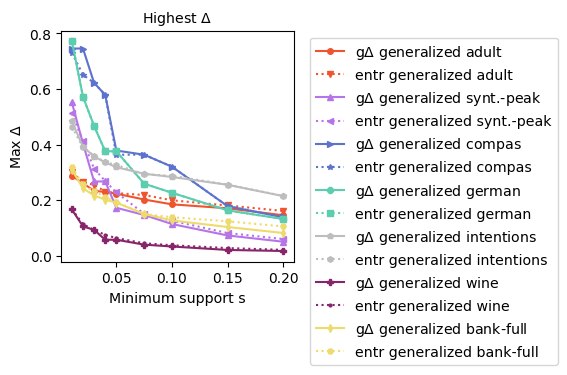

In [21]:
output_results = os.path.join(os.path.curdir, output_dir, 'performance')
from pathlib import Path

Path(output_results).mkdir(parents=True, exist_ok=True)
info_plot = {}


for dataset_name_file, metric in zip(datasets, metrics):
    if dataset_name_file == 'folkstables':
        continue
    dataset_name = _rename_dataset(dataset_name_file)


    results_all[dataset_name] = {'time':{}, 'fp': {}, f'max_{metric}' :{}}
    for type_criterion in type_criterions:
        
        pruning_type = ''
        
        
        conf_name = f"{dataset_name_file}_{metric}_{type_criterion}_{min_support_tree}{pruning_type}_i"
        
        conf_name = f'{conf_name[:-2]}_top_1000_i'
            
                
        
        if os.path.isfile(os.path.join(output_results, f'{conf_name}_time.json')):
            with open(os.path.join(output_results, f'{conf_name}_time.json')) as json_file:
                results_all[dataset_name]['time'][type_criterion] = json.load(json_file)

            with open(os.path.join(output_results, f'{conf_name}_fp.json')) as json_file:
                results_all[dataset_name]['fp'][type_criterion] = json.load(json_file)

            with open(os.path.join(output_results, f'{conf_name}_div.json')) as json_file:
                results_all[dataset_name][f'max_{metric}' ][type_criterion] = json.load(json_file)    
        else:
            print(os.path.join(output_results, f'{conf_name}_time.json'))
            print(f'{conf_name} not available')
            

    info_i =f'max_{metric}' 
    results = results_all[dataset_name][info_i]

    for type_criterion in  type_criterions:
        if type_criterion in results:
            for sup in sorted(results[type_criterion].keys()):
                for type_gen in type_gens :
                    type_gen_str = abbreviateValue(f"{type_criterion}_{type_gen}_{dataset_name}", abbreviations)
                    if type_gen_str not in info_plot:
                        info_plot[type_gen_str] = {}
                    info_plot[type_gen_str][float(sup)] = results[type_criterion][sup][type_gen]


    for type_gen_str in info_plot:
        info_plot[type_gen_str] = dict(sorted(info_plot[type_gen_str].items()))


    title, ylabel = '', ''
    if info_i == 'time':
        title = 'Execution time'
        ylabel="Execution time $(seconds)$"

    elif info_i == f"max_{metric}":
        m = metric[2:].upper()

        ylabel=f"Max $\\Delta$"
        title=f"Highest $\\Delta$"

    elif info_i == 'FP':
        ylabel="#FP"
        title="#FP" 


    #figure_name = os.path.join(output_fig_dir, f"{dataset_name}_stree_{min_support_tree}_{metric}_{info_i}.pdf")
    figure_name = ''
    
    
size_fig = (3, 3)
plotDicts(info_plot, marker=True, \
            title=title, sizeFig=size_fig,\
                   linestyle=lines_style, color_labels=color_labels, \
            xlabel="Minimum support s",  ylabel=ylabel, labelSize=10.2,\
            outside=True,  saveFig=saveFig, nameFig = figure_name, legendSize=10.2)
        

# Plot in the paper

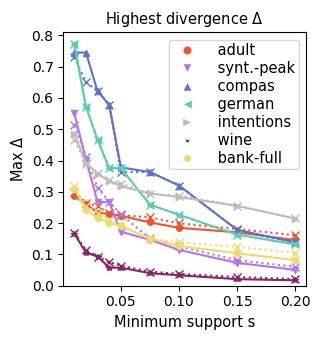

In [22]:
from utils_plot import MARKERS
from matplotlib.lines import Line2D



info_dicts = info_plot

marker=True
limit=(0, None)
nameFig=""
colorMap="tab10"
labelSize=10.5
markersize=4
linewidth=1.5
titleLegend=""
tickF=False
yscale="linear"
legendSize=10.5
saveFig=True
show_figure=True
xscale="linear"
linestyle = lines_style
borderpad=0.25
kformat=None

xlabel="Minimum support s"
ylabel=f"Max $\\Delta$"
title=f"Highest divergence $\\Delta$"

import matplotlib.pyplot as plt
import numpy as np

outside= False
sizeFig=(3.3, 3.5)



# plt.rcParams["figure.figsize"], plt.rcParams["figure.dpi"] = sizeFig, 100

fig, ax = plt.subplots(figsize=sizeFig, dpi=100)

if kformat:
    from matplotlib.ticker import FuncFormatter

    def kilos(x, pos):
        "The two args are the value and tick position"
        return f"{(x * 1e-3):.0f}k"

    formatter = FuncFormatter(kilos)

    ax.yaxis.set_major_formatter(formatter)

m_i = 0

MARKER_ENTROPY = 'x'

if color_labels is None:
    if colorMap:

        colors = plt.get_cmap(colorMap).colors
        if len(colors) < len(info_dicts):
            i = 0
            cs = ["Pastel1", "Pastel2"]
            while (len(colors) < len(info_dicts)) and (i < len(cs)):
                # TODO
                colors = list(colors) + list(plt.get_cmap(cs[i]).colors)
                i += 1
    else:
        import numpy as np

        colors = plt.cm.winter(np.linspace(0, 1, 20))
else:
    colors = [color_labels[label] for label in info_dicts]

keys = list(info_dicts.keys())
if linestyle == "-":
    linestyle = {k: "-" for k in keys}

m_i = 0
markers = {}
if marker:
    for label_name in info_dicts:
        if abbreviateValue('entropy', abbreviations) in label_name:
            marker_i = MARKER_ENTROPY
        else:
            marker_i = MARKERS[m_i] 
            m_i = m_i + 1
            if marker_i == MARKER_ENTROPY:
                # SKIP IT
                marker_i = MARKERS[m_i] 
                m_i = m_i + 1
        markers[label_name] = marker_i
        
for e, (label_name, info_dict) in enumerate(info_dicts.items()):
    if marker:
        marker_size = markersize if markers[label_name]!=MARKER_ENTROPY else markersize*1.5
        ax.plot(
            list(info_dict.keys()),
            list(info_dict.values()),
            label=label_name,
            marker=markers[label_name] if marker else None,
            linewidth=linewidth,
            markersize=marker_size,
            color=colors[e],
            linestyle=linestyle[label_name],
        )

import cycler

if colorMap:
    plt.rcParams["axes.prop_cycle"] = cycler.cycler(
        color=plt.get_cmap(colorMap).colors
    )
else:
    color = plt.cm.winter(np.linspace(0, 1, 10))
    plt.rcParams["axes.prop_cycle"] = cycler.cycler("color", color)

if limit is not None:
    plt.ylim(top=limit[1], bottom=limit[0])

if not kformat and tickF:
    print("bbb")
    xt = list(info_dict.keys())
    plt.xticks(
        [xt[i] for i in range(0, len(xt)) if i == 0 or xt[i] * 100 % 5 == 0],
        fontsize=labelSize,
    )

plt.xlabel(xlabel, fontsize=labelSize)
plt.ylabel(ylabel, fontsize=labelSize)
plt.title(title, fontsize=labelSize)



plt.xscale(xscale)
if not kformat:
    plt.yscale(yscale)
    
l = ax.get_legend_handles_labels()
handles, labels = ax.get_legend_handles_labels()
idxs = [i for i, l in enumerate(labels) if abbreviateValue('divergence_criterion', abbreviations) in l]
#handles = [handles[i] for i in idxs]
legend_handles = [Line2D([0], [0], marker=handles[i]._marker, color='w', label='Scatter',
                              markerfacecolor=handles[i]._color, markersize=handles[i]._markersize*1.7)
                      for i in idxs]
labels = [labels[i].replace(abbreviateValue('divergence_criterion_generalized', abbreviations), '')for i in idxs]


if outside:
    plt.legend(handles = legend_handles, labels = labels,
        prop={"size": legendSize},
        bbox_to_anchor=(1.04, 1),
        loc="upper left",
        title=titleLegend,
        fontsize=5,
        title_fontsize=5,
    )
else:
    plt.legend(handles = legend_handles, labels = labels,
        prop={"size": legendSize},
        title=titleLegend,
        fontsize=legendSize,
        title_fontsize=legendSize,
        labelspacing=0.2,
        borderpad=borderpad,
    ) 
    
nameFig = os.path.join(output_fig_dir, 'div_entropy_comparison.pdf') 
if saveFig:
    fig.tight_layout()
    plt.savefig(nameFig, bbox_inches="tight")
if show_figure:
    plt.show()
    plt.close()

folkstables_d_outcome_entropy_0.1_top_1000_i not available


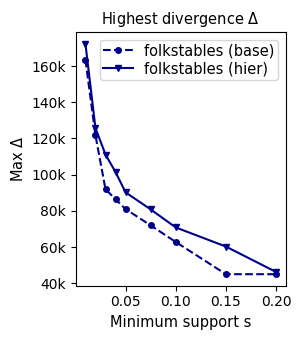

In [15]:
from utils_plot import MARKERS
from matplotlib.lines import Line2D



output_results = os.path.join(os.path.curdir, output_dir, 'performance')
from pathlib import Path

Path(output_results).mkdir(parents=True, exist_ok=True)
info_plot = {}


for dataset_name_file, metric in zip(datasets, metrics):
    if dataset_name_file != 'folkstables':
        continue
    dataset_name = _rename_dataset(dataset_name_file)


    results_all[dataset_name] = {'time':{}, 'fp': {}, f'max_{metric}' :{}}
    for type_criterion in type_criterions:
        
        pruning_type = ''
        
        
        conf_name = f"{dataset_name_file}_{metric}_{type_criterion}_{min_support_tree}{pruning_type}_i"
        conf_name = f'{conf_name[:-2]}_top_1000_i'
            
                
        
        if os.path.isfile(os.path.join(output_results, f'{conf_name}_time.json')):
            with open(os.path.join(output_results, f'{conf_name}_div.json')) as json_file:
                results_all[dataset_name][f'max_{metric}' ][type_criterion] = json.load(json_file)    
        else:
            print(f'{conf_name} not available')
            

    info_i =f'max_{metric}' 
    results = results_all[dataset_name][info_i]

    for type_criterion in  type_criterions:
        if type_criterion in results:
            for sup in sorted(results[type_criterion].keys()):
                for type_gen in ['base', 'generalized'] :
                    type_gen_str = abbreviateValue(f"{type_criterion}_{type_gen}_{dataset_name}", abbreviations)
                    if type_gen_str not in info_plot:
                        info_plot[type_gen_str] = {}
                    info_plot[type_gen_str][float(sup)] = results[type_criterion][sup][type_gen]


    for type_gen_str in info_plot:
        info_plot[type_gen_str] = dict(sorted(info_plot[type_gen_str].items()))

    

info_dicts = {k:v for k,v in info_plot.items() if 'folkstables' in k}

marker=True
limit= None
nameFig=""
colorMap="tab10"
labelSize=10.5
markersize=4
linewidth=1.5
titleLegend=""
tickF=False
yscale="linear"
legendSize=10.5
saveFig=True
show_figure=True
xscale="linear"
linestyle = lines_style
borderpad=0.25
kformat=True

xlabel="Minimum support s"
ylabel=f"Max $\\Delta$"
title=f"Highest divergence $\\Delta$"

import matplotlib.pyplot as plt
import numpy as np

outside= False
sizeFig=(3.1, 3.5)



# plt.rcParams["figure.figsize"], plt.rcParams["figure.dpi"] = sizeFig, 100

fig, ax = plt.subplots(figsize=sizeFig, dpi=100)

if kformat:
    from matplotlib.ticker import FuncFormatter

    def kilos(x, pos):
        "The two args are the value and tick position"
        return f"{(x * 1e-3):.0f}k"

    formatter = FuncFormatter(kilos)

    ax.yaxis.set_major_formatter(formatter)

m_i = 0

MARKER_ENTROPY = 'x'

if color_labels is None:
    if colorMap:

        colors = plt.get_cmap(colorMap).colors
        if len(colors) < len(info_dicts):
            i = 0
            cs = ["Pastel1", "Pastel2"]
            while (len(colors) < len(info_dicts)) and (i < len(cs)):
                # TODO
                colors = list(colors) + list(plt.get_cmap(cs[i]).colors)
                i += 1
    else:
        import numpy as np

        colors = plt.cm.winter(np.linspace(0, 1, 20))
else:
    colors = [color_labels[label] for label in info_dicts]

keys = list(info_dicts.keys())
if linestyle == "-":
    linestyle = {k: "-" for k in keys}

m_i = 0
markers = {}
if marker:
    for label_name in info_dicts:
        if abbreviateValue('entropy', abbreviations) in label_name:
            marker_i = MARKER_ENTROPY
        else:
            marker_i = MARKERS[m_i] 
            m_i = m_i + 1
            if marker_i == MARKER_ENTROPY:
                # SKIP IT
                marker_i = MARKERS[m_i] 
                m_i = m_i + 1
        markers[label_name] = marker_i
        
for e, (label_name, info_dict) in enumerate(info_dicts.items()):
    if marker:
        marker_size = markersize if markers[label_name]!=MARKER_ENTROPY else markersize*1.5
        ax.plot(
            list(info_dict.keys()),
            list(info_dict.values()),
            label=label_name,
            marker=markers[label_name] if marker else None,
            linewidth=linewidth,
            markersize=marker_size,
            color=colors[e],
            linestyle=linestyle[label_name],
        )

import cycler

if colorMap:
    plt.rcParams["axes.prop_cycle"] = cycler.cycler(
        color=plt.get_cmap(colorMap).colors
    )
else:
    color = plt.cm.winter(np.linspace(0, 1, 10))
    plt.rcParams["axes.prop_cycle"] = cycler.cycler("color", color)

if limit is not None:
    plt.ylim(top=limit[1], bottom=limit[0])

if not kformat and tickF:
    print("bbb")
    xt = list(info_dict.keys())
    plt.xticks(
        [xt[i] for i in range(0, len(xt)) if i == 0 or xt[i] * 100 % 5 == 0],
        fontsize=labelSize,
    )

plt.xlabel(xlabel, fontsize=labelSize)
plt.ylabel(ylabel, fontsize=labelSize)
plt.title(title, fontsize=labelSize)



plt.xscale(xscale)
if not kformat:
    plt.yscale(yscale)
    

l = ax.get_legend_handles_labels()
handles, labels = ax.get_legend_handles_labels()
custom_abbreviations = {'g$\\Delta$ base folkstables': 'folkstables (base)', 'g$\\Delta$ generalized folkstables': 'folkstables (hier)'}
labels = [abbreviateValue(l, custom_abbreviations) for l in labels]
legend_handles = handles
"""idxs = [i for i, l in enumerate(labels) if abbreviateValue('divergence_criterion', abbreviations) in l]
#handles = [handles[i] for i in idxs]
legend_handles = [Line2D([0], [0], marker=handles[i]._marker, color='w', label='Scatter',
                              markerfacecolor=handles[i]._color, markersize=handles[i]._markersize*1.7)
                      for i in idxs]
labels = [labels[i].replace(abbreviateValue('divergence_criterion_generalized', abbreviations), '')for i in idxs]
"""

if outside:
    plt.legend(handles = legend_handles, labels = labels,
        prop={"size": legendSize},
        bbox_to_anchor=(1.04, 1),
        loc="upper left",
        title=titleLegend,
        fontsize=5,
        title_fontsize=5,
    )
else:
    plt.legend(handles = legend_handles, labels = labels,
        prop={"size": legendSize},
        title=titleLegend,
        fontsize=legendSize,
        title_fontsize=legendSize,
        labelspacing=0.2,
        borderpad=borderpad,
    ) 
    
nameFig = os.path.join(output_fig_dir, 'div_folkstables.pdf') 
if saveFig:
    fig.tight_layout()
    plt.savefig(nameFig, bbox_inches="tight")
if show_figure:
    plt.show()
    plt.close()

In [16]:
{k: info_plot['g$\\Delta$ generalized folkstables'][k] - info_plot['g$\\Delta$ base folkstables'][k] for k in info_plot['g$\\Delta$ generalized folkstables']}

{0.01: 8816.108848939475,
 0.02: 4032.6530266951886,
 0.03: 19181.949187650025,
 0.04: 15048.679970655707,
 0.05: 9217.74236679406,
 0.075: 8828.536134980357,
 0.1: 8042.943049280468,
 0.15: 15272.496635171963,
 0.2: 1233.2059714384086}

In [17]:
output_results = os.path.join(os.path.curdir, output_dir, 'performance')
from pathlib import Path

Path(output_results).mkdir(parents=True, exist_ok=True)
info_plot = {}

for dataset_name_file, metric in zip(datasets, metrics):
    if dataset_name_file=='folkstables':
        continue
    
    dataset_name = _rename_dataset(dataset_name_file)


    results_all[dataset_name] = {'time':{}, 'fp': {}, f'max_{metric}' :{}}
    for type_criterion in type_criterions:
        
        pruning_type = ''
        
        
        conf_name = f"{dataset_name_file}_{metric}_{type_criterion}_{min_support_tree}{pruning_type}_i"

        if dataset_name_file == 'online_shoppers_intention' or dataset_name_file == 'wine' or dataset_name_file == 'bank-full':
            conf_name = f'{conf_name[:-2]}_top_1000_i'

                
        
        if os.path.isfile(os.path.join(output_results, f'{conf_name}_time.json')):
            with open(os.path.join(output_results, f'{conf_name}_time.json')) as json_file:
                results_all[dataset_name]['time'][type_criterion] = json.load(json_file)

            with open(os.path.join(output_results, f'{conf_name}_fp.json')) as json_file:
                results_all[dataset_name]['fp'][type_criterion] = json.load(json_file)

            with open(os.path.join(output_results, f'{conf_name}_div.json')) as json_file:
                results_all[dataset_name][f'max_{metric}' ][type_criterion] = json.load(json_file)    
        else:
            print(f'{conf_name} not available')
                        

    info_i =f'max_{metric}' 
    results = results_all[dataset_name][info_i]

    for type_criterion in  type_criterions:
        for sup in sorted(results[type_criterion].keys()):
            for type_gen in type_gens:
                type_gen_str = abbreviateValue(f"{type_criterion}_{type_gen}_{dataset_name}", abbreviations)
                if type_gen_str not in info_plot:
                    info_plot[type_gen_str] = {}
                info_plot[type_gen_str][float(sup)] = results[type_criterion][sup][type_gen]


    for type_gen_str in info_plot:
        info_plot[type_gen_str] = dict(sorted(info_plot[type_gen_str].items()))


    title, ylabel = '', ''
    if info_i == 'time':
        title = 'Execution time'
        ylabel="Execution time $(seconds)$"

    elif info_i == f"max_{metric}":
        m = metric[2:].upper()

        ylabel=f"Max $\\Delta_{{{m}}}$"
        title=f"Highest $\\Delta_{{{m}}}$"

    elif info_i == 'FP':
        ylabel="#FP"
        title="#FP" 


    #figure_name = os.path.join(output_fig_dir, f"{dataset_name}_stree_{min_support_tree}_{metric}_{info_i}.pdf")
    figure_name = ''
    
size_fig = (6, 3)
plotDicts(info_plot, marker=True, \
            title=title, sizeFig=size_fig,\
                   linestyle=lines_style, color_labels=color_labels, \
            xlabel="Minimum support s",  ylabel=ylabel, labelSize=10.2,\
            outside=True,  saveFig=saveFig, nameFig = figure_name, legendSize=10.2)
            




adult_d_error_divergence_criterion_0.1_i not available
adult_d_error_entropy_0.1_i not available


KeyError: 'divergence_criterion'

In [ ]:
output_results = os.path.join(os.path.curdir, output_dir, 'performance')
from pathlib import Path

Path(output_results).mkdir(parents=True, exist_ok=True)
info_plot = {}


for dataset_name_file, metric in zip(datasets, metrics):
    if dataset_name_file == 'folkstables':
        continue

    dataset_name = _rename_dataset(dataset_name_file)
    

    results_all[dataset_name] = {'time':{}, 'fp': {}, f'max_{metric}' :{}}
    for type_criterion in type_criterions:
        
        pruning_type = ''
        
        
        conf_name = f"{dataset_name_file}_{metric}_{type_criterion}_{min_support_tree}{pruning_type}_i"
        
        if dataset_name_file == 'online_shoppers_intention' or dataset_name_file == 'wine' or dataset_name_file == 'bank-full':
            conf_name = f'{conf_name[:-2]}_top_1000_i'


        
        if os.path.isfile(os.path.join(output_results, f'{conf_name}_time.json')):
            with open(os.path.join(output_results, f'{conf_name}_time.json')) as json_file:
                results_all[dataset_name]['time'][type_criterion] = json.load(json_file)

            with open(os.path.join(output_results, f'{conf_name}_fp.json')) as json_file:
                results_all[dataset_name]['fp'][type_criterion] = json.load(json_file)

            with open(os.path.join(output_results, f'{conf_name}_div.json')) as json_file:
                results_all[dataset_name][f'max_{metric}' ][type_criterion] = json.load(json_file)    
        else:
            print(f'{conf_name} not available')
            

    info_i =f'max_{metric}' 
    results = results_all[dataset_name][info_i]

    for type_criterion in ['entropy', 'divergence_criterion']:

        for sup in sorted(results[type_criterion].keys()):
            for type_gen in type_gens:
                type_gen_str = abbreviateValue(f"{type_gen}_{dataset_name}", abbreviations)
                if type_gen_str not in info_plot:
                    info_plot[type_gen_str] = {}
                if float(sup) not in info_plot[type_gen_str]:
                    info_plot[type_gen_str][float(sup)] = 0
                if type_criterion == 'entropy':
                    info_plot[type_gen_str][float(sup)] -= results[type_criterion][sup][type_gen]
                else:
                    info_plot[type_gen_str][float(sup)] += results[type_criterion][sup][type_gen]
                    


    for type_gen_str in info_plot:
        info_plot[type_gen_str] = dict(sorted(info_plot[type_gen_str].items()))


    title, ylabel = '', ''
    if info_i == 'time':
        title = 'Execution time'
        ylabel="Execution time $(seconds)$"

    elif info_i == f"max_{metric}":
        m = metric[2:].upper()

        ylabel=f"Max $\\Delta_{{{m}}}$"
        title=f"Highest $\\Delta_{{{m}}}$"

    elif info_i == 'FP':
        ylabel="#FP"
        title="#FP" 


    #figure_name = os.path.join(output_fig_dir, f"{dataset_name}_stree_{min_support_tree}_{metric}_{info_i}.pdf")
    figure_name = ''
    
    
size_fig = (6, 4)


plotDicts(info_plot, marker=True, \
            title=title, sizeFig=size_fig,\
                  #  linestyle=lines_style, color_labels=color_labels, \
            xlabel="Minimum support s",  ylabel=ylabel, labelSize=10.2,\
            outside=True,  saveFig=saveFig, nameFig = figure_name, legendSize=10.2)
            




In [ ]:
ii